<a href="https://colab.research.google.com/github/plaban1981/AI_Explainability/blob/main/Copy_of_DS_Dojo_Hands_on_Introduction_to_Interpretable_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on Introduction to Interpretable Machine Learning
## **Exercise**: _Interpreting an Employment Classifier for North Carolina_
### Workshop for Data Science Dojo — scheduled for September 7th, 2022 12:00 PM PST
### by Serg Masís ([LinkedIn](https://www.linkedin.com/in/smasis/), [Twitter](https://twitter.com/smasis), [Serg.ai](https://www.serg.ai/), [Github](https://github.com/smasis001), [Amazon](https://www.amazon.com/kindle-dbs/entity/author/B08PQ8P9BS?_encoding=UTF8&node=283155&offset=0&pageSize=12&searchAlias=stripbooks&sort=author-sidecar-rank&page=1&langFilter=default#formatSelectorHeader) ) 

https://www.youtube.com/c/Datasciencedojo/

## 1) Install Libraries

Always installed unless installed already:

In [1]:
!pip install imgaug==0.2.5 --force-reinstall
!yes|pip install --quiet git+https://github.com/christophM/rulefit.git
!yes|pip install --quiet git+https://github.com/SauceCat/PDPbox.git
!pip install folktables==0.0.11 catboost==0.24.1 imodels==1.3.0 interpret==0.2.7 shap==0.37.0 PyALE==1.1.2 lime==0.2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 562 kB 15.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 13.5 MB 28.8 MB/s 
     |████████████████████████████████| 15.7 MB 50.3 MB/s 
     |████████████████████████████████| 3.1 MB 43.9 MB/s 
     |████████████████████████████████| 40 kB 5.2 MB/s 
     |████████████████████████████████| 3.4 MB 46.0 MB/s 
     |████████████████████████████████| 1.9 MB 36.4 MB/s 
     |████████████████████████████████| 6.4 MB 31.1 MB/s 
     |████████████████████████████████| 178 kB 47.4 MB/s 
     |████████████████████████████████| 98 kB 7.6 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.5-py3-none-any.whl size=561438 sha256=c568f143ccdbb686568e1a778bce4632be9ce0cb5fff125d122fc4b79730868a
  Stored in directory: /root/.cache/pip/wheels/60/dd/38/d1dc2cad2b6a66dc0249261004990bccb0f27985c74ba26e49
Success

     |████████████████████████████████| 13.1 MB 14.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 66.0 MB 65.1 MB/s 
     |████████████████████████████████| 192 kB 75.4 MB/s 
     |████████████████████████████████| 326 kB 72.5 MB/s 
     |████████████████████████████████| 275 kB 65.6 MB/s 
     |████████████████████████████████| 1.3 MB 63.0 MB/s 
     |████████████████████████████████| 6.6 MB 62.8 MB/s 
     |████████████████████████████████| 5.8 MB 38.4 MB/s 
     |████████████████████████████████| 3.6 MB 57.1 MB/s 
     |████████████████████████████████| 9.9 MB 44.0 MB/s 
     |████████████████████████████████| 281 kB 68.7 MB/s 
     |████████████████████████████████| 756 kB 70.1 MB/s 
     |████████████████████████████████| 251 kB 60.9 MB/s 
     |████████████████████████████████| 1.6 MB 46.9 MB/s 
     |████████████████████████████████| 76 kB 6.0 MB/s 
     |█████████████████████████

Wait for all packages to install. You might need to restart runtime after installing them. It also might throw a few minor errors but still install them successfully.

## Problem Statement : Unemployment Classifier based on census data

## 2) Load Libraries

In [1]:
import math
import os
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=DeprecationWarning)

#DATA WRANGLING
import numpy as np
import pandas as pd
from folktables import ACSDataSource, ACSEmployment
from sklearn.model_selection import train_test_split

#MODELING
from tqdm.notebook import trange, tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics, linear_model, tree, naive_bayes,\
                    neighbors, ensemble, neural_network
import catboost as cb # gradient boosted decision trees
from rulefit import RuleFit
from imodels import FIGSClassifier
from interpret.glassbox import ExplainableBoostingClassifier

#VISUALIZATION & INTERPRETATION
import matplotlib.pyplot as plt
import seaborn as sns
from interpret import show #explainable boosting classifiers
from pdpbox import pdp, info_plots
from PyALE import ale
from lime.lime_tabular import LimeTabularExplainer
import shap

## 3) Data Understanding & Preparations

### 3.1) Load Dataset

These two lines will grab the Census data for one year and then subset the data for one state.

In [2]:
data_source = ACSDataSource(survey_year='2017', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["NC"], download=True)

### 3.2) Preprocess Steps

There are a few quick preprocessing steps we will need to do since we are only interested in certain features and individuals at least 16 years old. We will also convert a few categorical variables to binary format and turn our categorical target (`ESR`) into binary as well.

In [3]:
employment_df = ACSEmployment._preprocess(acs_data)\
                        [ACSEmployment.features + [ACSEmployment.target]].fillna(0).astype(int)
print(employment_df.head())
employment_df = employment_df[employment_df.AGEP >= 16]# take people of working age

employment_df['DIS'] = np.where(employment_df.DIS == 1, 1, 0)
employment_df['NATIVITY'] = np.where(employment_df.NATIVITY == 1, 1, 0)
employment_df['DEAR'] = np.where(employment_df.DEAR == 1, 1, 0)
employment_df['DEYE'] = np.where(employment_df.DEYE == 1, 1, 0)
employment_df['DREM'] = np.where(employment_df.DREM == 1, 1, 0)
#Traget Variable - Employment Status
employment_df['ESR'] = np.where((employment_df['ESR'] != 1) & (employment_df['ESR'] != 4), 1, 0)

   AGEP  SCHL  MAR  RELP  DIS  ESP  ...  DEAR  DEYE  DREM  SEX  RAC1P  ESR
0    38    16    1     0    2    0  ...     2     2     2    1      1    1
1    34    16    1     1    1    0  ...     1     2     2    2      1    1
2    17    14    5     2    2    1  ...     2     2     2    2      1    1
3    15    13    5     2    2    1  ...     2     2     2    2      1    0
4    11     9    5     2    2    1  ...     2     2     2    2      1    0

[5 rows x 17 columns]


In [4]:
employment_df.head()

AGEP  SCHL  MAR  RELP  DIS  ESP  ...  DEAR  DEYE  DREM  SEX  RAC1P  ESR
0    38    16    1     0    0    0  ...     0     0     0    1      1    0
1    34    16    1     1    1    0  ...     1     0     0    2      1    0
2    17    14    5     2    0    1  ...     0     0     0    2      1    0
5    58    18    1     0    0    0  ...     0     0     0    1      1    0
6    60    16    1     1    0    0  ...     0     0     0    2      1    1

[5 rows x 17 columns]

In [5]:
employment_df.shape

(83517, 17)

Better rename the columns to make them easier to interpret:

In [ ]:
employment_df = employment_df.rename(columns={'AGEP':'Age', 'SCHL':'Schooling', 'MAR':'Marital Status',\
                                              'RELP':'Relationship', 'DIS':'Disability', 'ESP':'Employment Status',\
                                              'CIT':'Citizen Status', 'MIG':'Mobility Status', 'MIL':'Military Service',\
                                              'ANC':'Ancestry', 'NATIVITY':'Nativity', 'DEAR':'Hearing Difficulty',\
                                              'DEYE':'Vision Difficulty', 'DREM':'Cognitive Difficulty', 'SEX':'Sex',\
                                              'RAC1P':'Race'})

### 3.3) Inspect Dataset

At a glance with `info()`:

In [ ]:
employment_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83517 entries, 0 to 101232
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Age                   83517 non-null  int64
 1   Schooling             83517 non-null  int64
 2   Marital Status        83517 non-null  int64
 3   Relationship          83517 non-null  int64
 4   Disability            83517 non-null  int64
 5   Employment Status     83517 non-null  int64
 6   Citizen Status        83517 non-null  int64
 7   Mobility Status       83517 non-null  int64
 8   Military Service      83517 non-null  int64
 9   Ancestry              83517 non-null  int64
 10  Nativity              83517 non-null  int64
 11  Hearing Difficulty    83517 non-null  int64
 12  Vision Difficulty     83517 non-null  int64
 13  Cognitive Difficulty  83517 non-null  int64
 14  Sex                   83517 non-null  int64
 15  Race                  83517 non-null  int64
 16  ESR

or with `sample()`:

In [ ]:
employment_df.sample(10)

Age  Schooling  Marital Status  Relationship  Disability  \
54235   38         19               1             1           0   
34106   68         17               1             0           0   
69182   38         21               1             0           0   
16348   55         16               4             0           0   
3553    58         19               5             0           1   
72190   53         16               1             0           0   
91565   34         19               1             0           0   
87534   60         16               1             0           0   
92444   72         16               1             1           1   
2381    79         21               1             0           0   

       Employment Status  Citizen Status  Mobility Status  Military Service  \
54235                  0               1                3                 4   
34106                  0               1                1                 4   
69182                  0               1                1                 4   
16348                  0               1                1                 2   
3553                   0               1                1                 2   
72190                  0               1                1                 2   
91565                  0               1                1                 4   
87534                  0               1                1                 4   
92444                  0               1                1                 4   
2381                   0               1                1                 2   

       Ancestry  Nativity  Hearing Difficulty  Vision Difficulty  \
54235         4         1                   0                  0   
34106         1         1                   0                  0   
69182         2         1                   0                  0   
16348         1         1                   0                  0   
3553          1         1                   0                  0   
72190         2         1                   0                  0   
91565         2         1                   0                  0   
87534         2         1                   0                  0   
92444         1         1                   0                  0   
2381          1         1                   0                  0   

       Cognitive Difficulty  Sex  Race  ESR  
54235                     0    1     2    1  
34106                     0    2     1    1  
69182                     0    2     1    1  
16348                     0    2     2    0  
3553                      0    1     1    0  
72190                     0    1     1    0  
91565                     0    2     1    0  
87534                     0    1     1    1  
92444                     0    2     1    1  
2381                      0    1     1    1

We won't have time to do proper EDA in the session but I'd recommend at least running [`pandas-profiling`](https://github.com/ydataai/pandas-profiling) on it.

In the meanwhile, here's a summarised data dictionary:

- `Age`: ordinal, age
- `Schooling`: ordinal, educational attainment (0: too young, 1: no schooling, 2: preschool,... 24: doctorate)
- `Marital Status`: categorical, marital status (1: married, 2:widowed, 3:divorced, 4:seperated, 5:never married or too young)
- `Relationship`: categorical, relationship (0: reference person, 1:spouse, 2:biological child,... 17:noninstitutionalized group quarters population)
- `Disability`: binary, disability (1: with a disability, 0:without)
- `Employment Status`: categorical, employment status of parents (0: n/a, 1:living with two parents & both parents employed,... 8:living with mother & mother not in labor force) 
- `Citizen Status`: categorical, citizen status (1:born in the US, 2: born in US territories, 3:born abroad to US parents, 4:US citizen by naturalization, 5:not a citizen)
- `Mobility Status`: categorical, mobility status from a year ago (1: yes, same house, 2:no, internationally, 3:no, different house in US)
- `Military Service`: categorical, military service (0: n/a, 1:in active duty now, 2:used to be in duty, 3:only for training in reserves, 4:never served)
- `Ancestry`: categorical, ancestry (1: single, 2:multiple, 3:unclassified, 4:not reported,...)
- `Nativity`: binary, nativity (1:native born, 0:foreign born)
- `Hearing Difficulty`: binary, hearing difficulty (1: yes, 0:no)
- `Vision Difficulty`: binary, vision difficulty (1:yes, 0:no)
- `Cognitive Difficulty`: binary, cognitive difficulty (1:yes, 0:no)
- `Sex`: categorical, sex (1: male, 2:female)
- `Race`: categorical, recoded detailed race code (1:white, 2:black, 3:american indian, 4:alaska native,... 9:two or more races)
- `ESR`: binary, target, employment status but changed original encoding (0: Working, 1: Not Working including unemployed and retired)

You can learn for about the FOLKTABLES package and the ACS data source in the [Github repository](https://github.com/zykls/folktables) or in the corresponding academic paper:

> Ding, F., Hardt, M., Miller, J., & Schmidt, L. (2021). Retiring Adult: New Datasets for Fair Machine Learning. [ArXiv, abs/2108.04884](https://arxiv.org/pdf/2108.04884.pdf).

### 3.4) Check Imbalance

Even though we won't do a full EDA, one thing that it's important to note is class balance. Some folks use bar plots but what's important here is what is the percentage of people in the positive class — that is, those that are not working.

In [8]:
print("Percentage Not Working:\t%.1f%%" % ((employment_df['ESR'].sum() / employment_df['ESR'].shape[0])*100))

Percentage Not Working:	45.6%


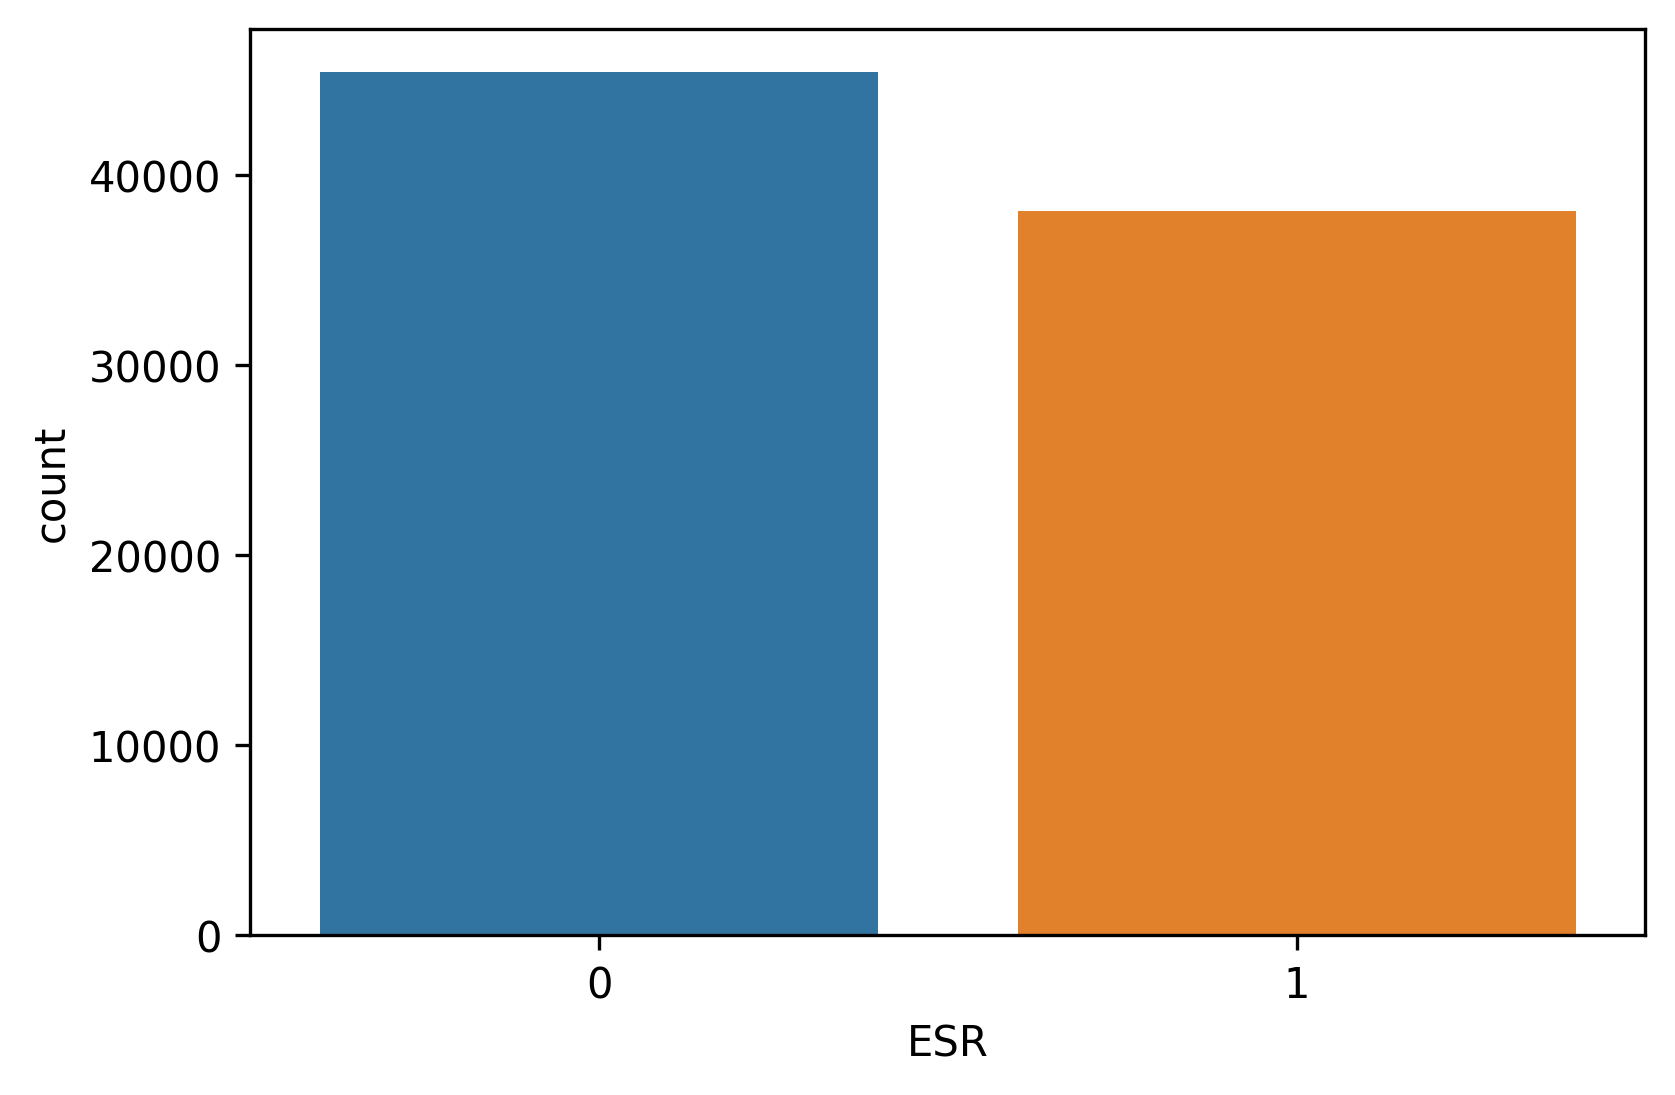

In [7]:
import seaborn as sns
sns.countplot(x='ESR',data=employment_df)
plt.show()

### 3.5) Final Preparation Steps

Define a seed for reproducibility:

In [9]:
rand = 42
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)

Define `X` and `y` and then test/train split them, as well as make lists for our classes (`class_l`) and features (`feature_l`).

In [10]:
class_l = ['Working','Not Working']

X = employment_df.drop(['ESR'], axis=1)
y = employment_df['ESR']
feature_l = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rand)

## 4) Modeling & Evaluation

### 4.1) Define Models to train

We will quickly train 10 models. 

In [11]:
class_models = {
        #Generalized Linear Models (GLMs)
        'logistic':{'model': make_pipeline(StandardScaler(), 
                                           linear_model.LogisticRegression(C=10,  penalty='l1', solver='liblinear',\
                                                                           random_state=rand, class_weight='balanced'))},  
    
        #Naive Bayes
        'naive_bayes':{'model': naive_bayes.GaussianNB()},
    
        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsClassifier(n_neighbors=7, algorithm='kd_tree', n_jobs=-1)},
    
        #Tree
        'decision_tree':{'model': tree.DecisionTreeClassifier(max_depth=3, class_weight='balanced',\
                                                              random_state=rand)},

    
        #Interpretable rule-based models
        'figs':{'model': FIGSClassifier(max_rules=11, random_state=rand),\
                'fit_args':{'feature_names':feature_l}},
        'rulefit':{'model': RuleFit(rfmode='classify', max_rules=11, random_state=rand, n_jobs=-1),\
                   'fit_args':{'feature_names':feature_l}},
    
        #Interpretable GAM-based models
        'ebm':{'model': ExplainableBoostingClassifier(random_state=rand, learning_rate=0.03, n_jobs=-1)},
    
        #Ensemble Methods
        'random_forest':{'model':ensemble.RandomForestClassifier(max_depth=5, class_weight='balanced',\
                                                                 random_state=rand)},
        'catboost':{'model': cb.CatBoostClassifier(max_depth=3, scale_pos_weight=1.3, random_state=rand,\
                                                   verbose=0)},
    
        #Neural Networks
        'mlp':{'model':make_pipeline(MinMaxScaler(),\
                                     neural_network.MLPClassifier(hidden_layer_sizes=(8,), max_iter=500,\
                                                   early_stopping=True, random_state=rand))}
    }

A couple of disclaimers:

- No hyperparameter tuning since I've already predetermined some good hyperparameters. 
- It's highly recommended to evaluate on Stratified K-Fold cross-validation but we won't have time to do that now. In any case, the results won't be too far from the CV averages.

In [12]:
class_models

{'logistic': {'model': Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('logisticregression',
                   LogisticRegression(C=10, class_weight='balanced', penalty='l1',
                                      random_state=42, solver='liblinear'))])},
 'naive_bayes': {'model': GaussianNB()},
 'knn': {'model': KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=7)},
 'decision_tree': {'model': DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=42)},
 'figs': {'model': FIGSClassifier(max_rules=11, random_state=42),
  'fit_args': {'feature_names': ['AGEP',
    'SCHL',
    'MAR',
    'RELP',
    'DIS',
    'ESP',
    'CIT',
    'MIG',
    'MIL',
    'ANC',
    'NATIVITY',
    'DEAR',
    'DEYE',
    'DREM',
    'SEX',
    'RAC1P']}},
 'rulefit': {'model': RuleFit(max_iter=1000, max_rules=11, n_jobs=-1, random_state=42,
          rfmode='classify'),
  'fit_args': {'feature_names': ['AGEP',
    'SCHL',
    'MAR',
    'RELP',
  

### 4.2) Batch train and evaluate

It should take 1-3 minutes to iterate across all models `fit`, `predict` and `score` them:

In [13]:
%%time
for model_name in tqdm(class_models.keys()):
    fitted_model = class_models[model_name]['model']
    if 'fit_args' in class_models[model_name]:
        fitted_model.fit(X_train.values, y_train.values,\
                         **class_models[model_name]['fit_args'])
        y_train_pred = fitted_model.predict(X_train.values)
        y_test_prob = fitted_model.predict_proba(X_test.values)[:,1]
    else:
        fitted_model.fit(X_train, y_train)
        y_train_pred = fitted_model.predict(X_train)
        y_test_prob = fitted_model.predict_proba(X_test)[:,1]
    y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    class_models[model_name]['pred_test'] = y_test_pred
    class_models[model_name]['prob_test'] = y_test_prob
    class_models[model_name]['acc_train'] = metrics.accuracy_score(y_train.values, y_train_pred)
    class_models[model_name]['acc_test'] = metrics.accuracy_score(y_test.values, y_test_pred)
    class_models[model_name]['precision'] = metrics.precision_score(y_test.values, y_test_pred)
    class_models[model_name]['recall'] = metrics.recall_score(y_test.values, y_test_pred)
    class_models[model_name]['f1'] = metrics.f1_score(y_test.values, y_test_pred)
    class_models[model_name]['roc-auc'] = metrics.roc_auc_score(y_test.values, y_test_prob)
    class_models[model_name]['mcc'] = metrics.matthews_corrcoef(y_test.values, y_test_pred)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 1min 28s, sys: 21.9 s, total: 1min 50s
Wall time: 1min 28s


### 4.3) Compare models
#### _Model selection_?

The following code simply takes the dictionary produced in the previous step and converts it into a dataframe. It also formats it to have the top 4 models for every metric color-coded.

In [14]:
def set_header_font():
    return [dict(selector="th", props=[("font-size", "14pt")])]

class_metrics_df = pd.DataFrame.from_dict(class_models, 'index').drop(['model','fit_args','pred_test','prob_test'], axis=1)
class_metrics_df = class_metrics_df*100
class_metrics_df.sort_values(by='f1', ascending=False).style.\
    format(dict(zip(class_metrics_df.columns, ['{:.1f}']*7))).\
    set_properties(**{'font-size': '13pt'}).set_table_styles(set_header_font()).\
    background_gradient(cmap='plasma', low=0.3, high=0.1, subset=['acc_train', 'acc_test']).\
    background_gradient(cmap='viridis', low=0.3, high=0.1, subset=['precision','recall',\
                                                                 'f1', 'mcc']).\
    highlight_quantile(q_left=0, q_right=0.6, props='color:black; background-color:inherit').\
    highlight_max(props='font-weight:bold;')

## We can definitely use stratified sampling for cross validation Stratified KFold validation or even in train test split

Usually this is the extent of all model interpretation performed. Solely for model-selection purposes which is like piloting an old-fashioned plane with half a dozen instruments. Indeed, Interpretable ML (or XAI) is like the collection of tools used to "pilot" AI/ML.

![AI Right Now](https://github.com/smasis001/av-2022/blob/main/AI-Right-Now.png?raw=1)

Which plane would you rather pilot (or be a passenger in)? Be honest! Left or right? 

Just as additional instrumentation in planes makes flying safer, additional instrumentation in ML can make predictive modelling fairer, more robust, and overall, more trustworthy.

### 4.4) Error analysis
#### _An introduction_

It makes sense to look further into how misclassification are distributed in order to understand how model error can impact reliability, safety, and fairness. This is a broad topic and there are better tools to perform just this task. I highly recommend Microsoft's open source [Error Analysis tool](https://techcommunity.microsoft.com/t5/ai-machine-learning-blog/responsible-machine-learning-with-error-analysis/ba-p/2141774). We won't use it here but I will provide a quick example of how error distribution can impact outcomes.

Firstly, in order to simplify comparing cohorts we will translate encoded categories into labels so we will create dictionaries that match a code to a label:

In [18]:
race_dict = {1: 'White', 2: 'Black', 3: 'Other', 4: 'Other', 5: 'Other', 6: 'Asian',\
             7: 'Other', 8: 'Other', 9: 'Other'}
sex_dict = {1: 'Male', 2:'Female'}

In [20]:
X_test.columns

Index(['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
       'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P'],
      dtype='object')

Then, the following functions can group the dataframe by a variable and then compute predictive performance metrics for that group alone:

In [16]:
def metrics_by_group(s):
    accuracy = metrics.accuracy_score(s.y_true, s.y_pred) * 100
    precision = metrics.precision_score(s.y_true, s.y_pred) * 100
    recall = metrics.recall_score(s.y_true, s.y_pred) * 100
    f1 = metrics.f1_score(s.y_true, s.y_pred) * 100
    roc_auc = metrics.roc_auc_score(s.y_true, s.y_prob) * 100
    tn, fp, fn, tp = metrics.confusion_matrix(s.y_true, s.y_pred).ravel()
    fnr = (fn/(tp+fn)) * 100
    fpr = (fp/(tn+fp)) * 100
    support = len(s.y_true)

    return pd.Series((support, accuracy, precision, recall, f1, roc_auc, fnr, fpr),\
                     index=['support', 'accuracy', 'precision', 'recall', 'f1', 'roc-auc', 'fnr', 'fpr'])

def error_breakdown_by_group(mdl_name, group_col, replace_dict, group_name=None):
    mdl = class_models[mdl_name]
    if group_name is None:
        group_name = group_col
    print('Error breakdown for model "%s" and group "%s"' % (mdl_name, group_name))
        
    predict_df = pd.DataFrame({group_name: X_test[group_col].replace(replace_dict).tolist(),\
                              'y_true': y_test.tolist(),
                              'y_pred': mdl['pred_test'],
                              'y_prob': mdl['prob_test']}, index=X_test.index)

    group_metrics_df = predict_df.groupby([group_name]).apply(metrics_by_group)

    html = group_metrics_df.sort_values(by='support', ascending=False).style.\
            format({'support':'{:,.0f}', 'accuracy':'{:.1f}%', 'precision':'{:.1f}%', 'recall':'{:.1f}%',\
                    'f1':'{:.1f}%', 'roc-auc':'{:.1f}%', 'fnr':'{:.1f}%', 'fpr':'{:.1f}%'}).\
            set_properties(**{'font-size': '13pt'}).set_table_styles(set_header_font()).\
            highlight_max(subset=['accuracy','precision','recall','f1','roc-auc']).\
            highlight_min(subset=['fnr','fpr'])
    
    return html

Here we will use this function to compute predictive performance by race:

In [22]:
error_breakdown_by_group('catboost', 'RAC1P', race_dict)

Error breakdown for model "catboost" and group "RAC1P"


As you can see two races top most metrics.

We can do the same for sex now:

In [21]:
error_breakdown_by_group('catboost', 'SEX', sex_dict)

Error breakdown for model "catboost" and group "SEX"


Again, one group is favored by the model.

There's a whole host of tools used to quantify bias and then mitigate it. I recommend [AI Fairness 360](https://github.com/Trusted-AI/AIF360).

But starting to understand a model starts with the foundation:

![FAT Diagram](https://github.com/smasis001/av-2022/blob/main/FAT_diagram2v2_LI.gif?raw=1)

As you can appreciate in the diagram, transparency is at the bottom so we need to understand the models first and foremost. So, let's...

> # DIG DEEPER!

## 5) Model explanations/interpretations

This section is about learning how the model works or at least an interpretation of how it's arriving to it's predictions.

When looking under the hood some models are priviledged with simple mechanisms. These are typically referred to as **White Box**. On the other hand, **Black Box** models are too complex to make sense us. For the former we can use **model-specific methods** and for the latter mostly **model-agnostic methods** are used.

![White Box, Black Box](https://github.com/smasis001/av-2022/blob/main/WhiteBoxBlackBox.png?raw=1)

### 5.1) Model-specific (using intrinsic parameters)

#### 5.1.1) Logistic Regression

Logistic regression, like all Generalized Linear Models (GLM), has a mathematical formula: 

$P(\hat{y}^{(i)}=1) = \huge{\frac{e^{\beta_0 + \beta_1 X_1^{(i)} + \beta_2 X_2^{(i)} \text{...}  + \beta_n X_n^{(i)}}}{1 + e^{\beta_0 + \beta_1 X_1^{(i)} + \beta_2 X_2^{(i)} \text{...}  + \beta_n X_n^{(i)}}}}$

The $\beta$'s are the coefficients (the $\beta_0$ being the intercept). If you wanted to, you could reconstruct the formula from a model. You can start by extracting the coefficients and intercept like this.

In [23]:
coefs_log = class_models['logistic']['model'].steps[1][1].coef_[0]
intercept_log = class_models['logistic']['model'].steps[1][1].intercept_
print('coefficients:\t%s' % coefs_log)
print('intercept:\t%s' % intercept_log)

coefficients:	[ 0.98619248 -0.42473723  0.2396962   0.46803474  0.51392725  0.33530546
 -0.01129961  0.05094877 -0.14350269 -0.06009398  0.03777153 -0.0875011
 -0.05025978  0.13540271  0.29329718  0.03358814]
intercept:	[0.03766262]


The rest is simply some simple math such as a dot product.

In any case, although it's helpful to understand the math, it's more important to understand what matters most to the model. Fortunately since the features had already been standarized in the `sklearn` pipeline, the coefficients already tell this story. All we have to do is take their absolute value and rank them. And voilá! We have the feature importance for the logistic regression model.

In [24]:
pd.DataFrame({'feature':feature_l, 'coef':np.abs(coefs_log)}).sort_values('coef', ascending=False).style.\
            set_properties(**{'font-size': '13pt'}).set_table_styles(set_header_font())

Another model that has coefficients that can be understood as part of a mathematical formula is **Naive Bayes**.

On the other hand, **K-Nearest Neighbors** can't be understood as a mathematical formula because all it is training data which when predicting uses the `k` closest points in the training data to make predictions. This can be easily understood on a instance by instance basis by retrieving the closest points.

#### 5.1.2) Decision Tree

Decision tree is one of the most intuitive models to understand. Our model only has a depth of three too which makes it even easier:

In [25]:
text_tree = tree.export_text(class_models['decision_tree']['model'],\
               feature_names=feature_l)
print(text_tree)

|--- AGEP <= 62.50
|   |--- RELP <= 1.50
|   |   |--- DIS <= 0.50
|   |   |   |--- class: 0
|   |   |--- DIS >  0.50
|   |   |   |--- class: 1
|   |--- RELP >  1.50
|   |   |--- AGEP <= 19.50
|   |   |   |--- class: 1
|   |   |--- AGEP >  19.50
|   |   |   |--- class: 0
|--- AGEP >  62.50
|   |--- AGEP <= 68.50
|   |   |--- DIS <= 0.50
|   |   |   |--- class: 1
|   |   |--- DIS >  0.50
|   |   |   |--- class: 1
|   |--- AGEP >  68.50
|   |   |--- AGEP <= 75.50
|   |   |   |--- class: 1
|   |   |--- AGEP >  75.50
|   |   |   |--- class: 1



As you can see, `Age` is a super prominent feature and there are only eight leaves.

We can plot a graph with the tree too with even more details:

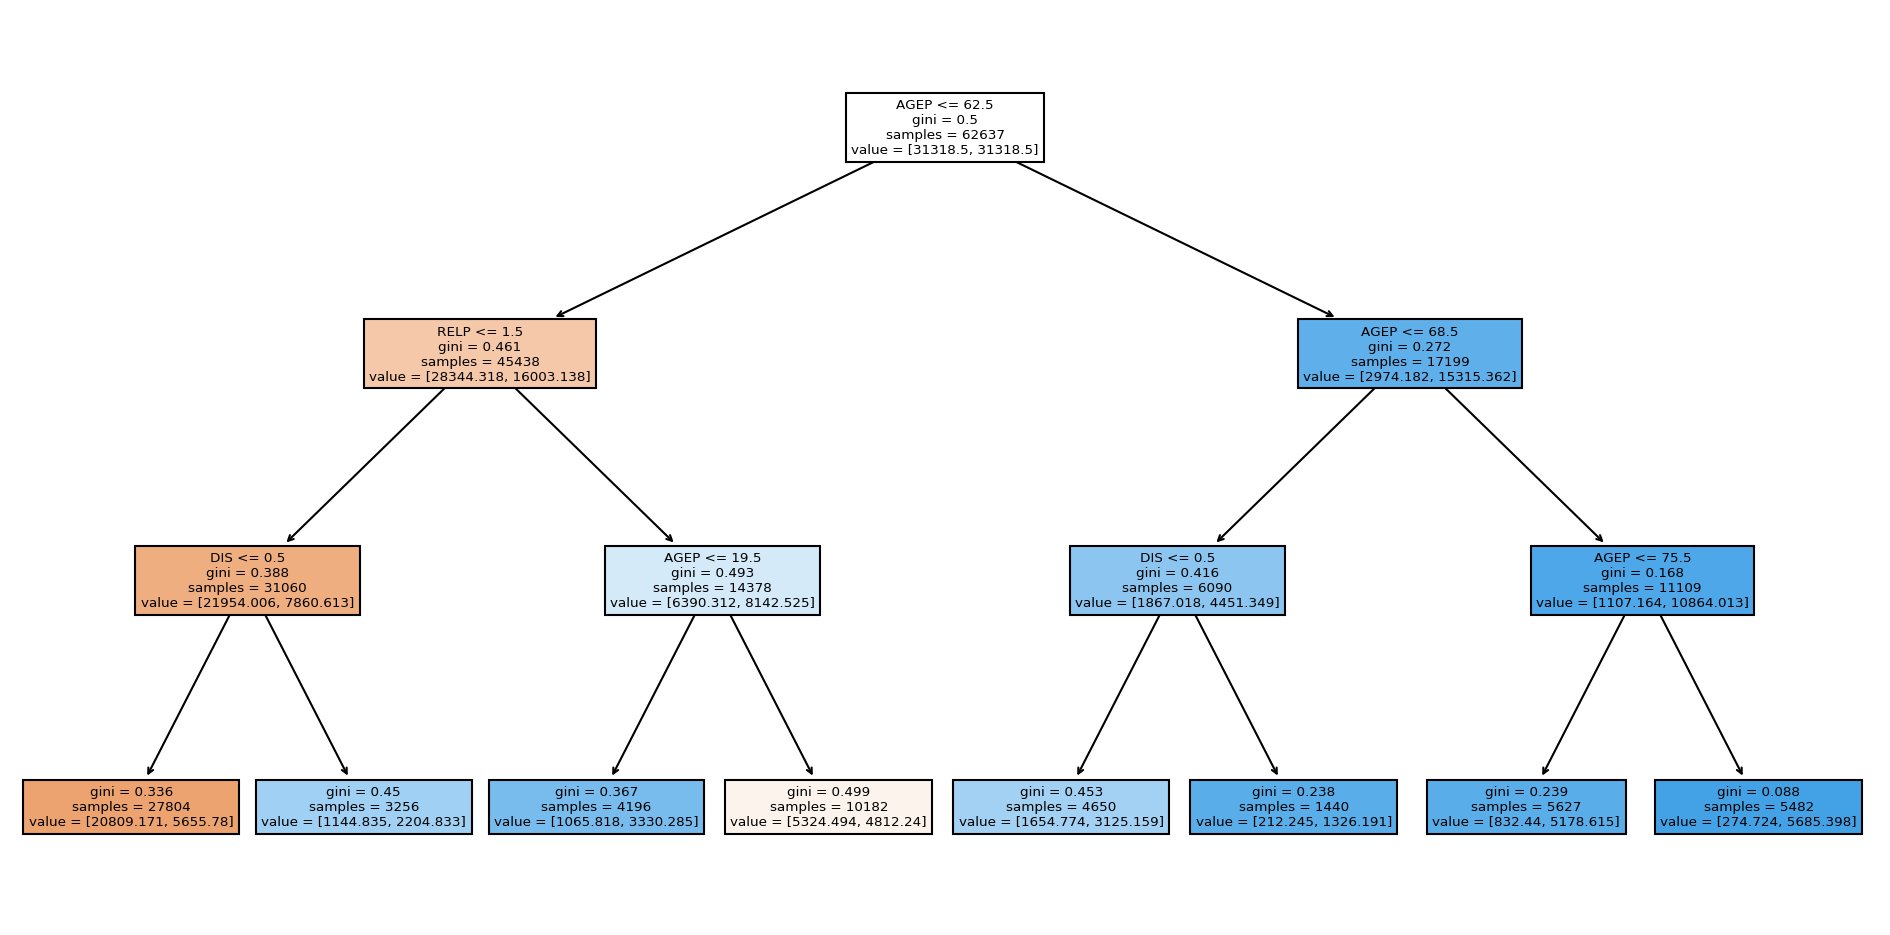

In [26]:
%matplotlib inline
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8), dpi=150)
tree.plot_tree(class_models['decision_tree']['model'], feature_names=feature_l,\
               filled=True, max_depth=3)
fig.show()

As you can see, each node has a **gini coefficient**. It can use this to tally the importances of each feature:

In [27]:
dt_imp_df = pd.DataFrame({'feature':feature_l,\
                        'importance': class_models['decision_tree']['model'].feature_importances_})
dt_imp_df.sort_values(by='importance', ascending=False).style.\
            set_properties(**{'font-size': '13pt'}).set_table_styles(set_header_font())

It shouldn't surprise you that only three features have importances because the three only uses three of the features!

#### 5.1.3) Fast interpretable greedy-tree sums (FIGS)

This is a new interpretable tree-based model, which is very promising.

![FIGS diagram](https://github.com/smasis001/av-2022/blob/main/FIGS_Figure1.png?raw=1)

> Tan, Y.S., Singh, C., Nasseri, K., Agarwal, A., & Yu, B. (2022). Fast Interpretable Greedy-Tree Sums (FIGS). [ArXiv, abs/2201.11931](https://arxiv.org/abs/2201.11931).

It's more than one tree, and each tree adds to make the predictions:

In [28]:
figs_mdl = class_models['figs']['model']
print(figs_mdl.__str__())

> ------------------------------
> FIGS-Fast Interpretable Greedy-Tree Sums:
> 	Predictions are made by summing the "Val" reached by traversing each tree
> ------------------------------
AGEP <= 62.500 (Tree #0 root)
	RELP <= 1.500 (split)
		SEX <= 1.500 (split)
			Val: 0.177 (leaf)
			Val: 0.315 (leaf)
		AGEP <= 19.500 (split)
			Val: 0.753 (leaf)
			RELP <= 15.500 (split)
				Val: 0.366 (leaf)
				MIL <= 1.500 (split)
					Val: -0.003 (leaf)
					Val: 0.740 (leaf)
	AGEP <= 68.500 (split)
		Val: 0.692 (leaf)
		Val: 0.880 (leaf)

	+
DIS <= 0.500 (Tree #1 root)
	Val: -0.048 (leaf)
	AGEP <= 62.500 (split)
		AGEP <= 34.500 (split)
			Val: 0.144 (leaf)
			Val: 0.376 (leaf)
		Val: 0.112 (leaf)

	+
SCHL <= 19.500 (Tree #2 root)
	Val: 0.023 (leaf)
	Val: -0.070 (leaf)



This can be easily read by splitting on feature values on every branch. You can even extract "rules" from traversing every tree till each leave and then the models' rules are the cardinal product of every trees' rules.

#### 5.1.4) RuleFit

RuleFit extracts rules from a Gradient Boosted Decision Tree and converts them into a binary feature.

It, then, fits a regularized logistic regression model to the rules (and optionally) the original features themselves.

> Friedman, J.H., & Popescu, B.E. (2008). PREDICTIVE LEARNING VIA RULE ENSEMBLES. The Annals of Applied Statistics, 2, 916-954. [arXiv:0811.1679](https://arxiv.org/abs/0811.1679)

You can extract the RuleFit rules, coefficients and intercept like this:

In [29]:
rulefit_mdl = class_models['rulefit']['model']

print('# Rules:\t%s' % len(rulefit_mdl.rule_ensemble.rules))
print('# Coefficients:\t%s' % len(rulefit_mdl.coef_))
print('Intercept:\t%.3f' % (rulefit_mdl.intercept_))

# Rules:	13
# Coefficients:	29
Intercept:	0.000


As you can see there are 29 coefficients but 13 rules. The difference is due to 16 coefficients belonging to the original features. You can also use the `get_rules` function to get a dataframe with all the model details:

In [30]:
rule_df = rulefit_mdl.get_rules()

Now let's display the dataframe without rules with a coeffcient of zero. Because RuleFit uses L1 regularization there are plenty of rules left out.

In [31]:
rule_df['support'] = rule_df['support'] * 100
rule_df['rule'] = rule_df.rule.str.replace(' & ',' &<br/>')

rule_df[rule_df.coef != 0].sort_values(["importance"], ascending=False).style.\
    format({'support':'{:.1f}%', 'importance':'{:.3f}'}).\
    bar(subset=['support'], color='#4EF', width=50).\
    set_properties(**{'font-size': '16pt'}).set_table_styles(set_header_font())

Support shows what percentage of the training dataset was supported by that rule.

#### 5.1.5) Explainable Boosting Machines

EBM leverages the Generalized Additive Models (GAM)s, which are like linear models but look like this:

$\large{\hat{y} = g(E[y]) = \beta_0 + f_1(x_1) + f_2(x_2) + \text{...} + f_j(x_j)}$

Individual functions $f_1$ through $f_p$ are fitted to each feature using spline functions. Then a link function $g$ adapts the GAM to perform different tasks such as classification or regression, or adjust predictions to different statistical distributions. 

EBM incorporates bagging and gradient boosting, which tend to make models more performant. The boosting is done one feature at a time using a low learning rate not to confound them. It also finds practical interaction terms automatically, which improves performance while maintaining interpretability:

$\large{\hat{y} = g(E[y]) = \beta_0 + \sum f_j(x_j) + \sum f_{ji}(x_j, x_i)}$

Once fitted, this formula is made up of complicated non-linear formulas, so a global holistic interpretation isn't likely feasible. However, since the effects of each feature or pairwise interaction terms are additive, they are easily separable, global modular interpretation is entirely possible. 

> Lou, Y., Caruana, R., Gehrke, J., & Hooker, G. (2013). Accurate intelligible models with pairwise interactions. Proceedings of the 19th ACM SIGKDD international conference on Knowledge discovery and data mining. [DOI:10.1145/2487575.2487579](https://dl.acm.org/doi/10.1145/2487575.2487579)

In [32]:
ebm_mdl = class_models['ebm']['model']
ebm_explanation = ebm_mdl.explain_global()

show(ebm_explanation)

So what to do with **Random Forest**, **Catboost**, and **MLP**?

### 5.2) Model-agnostic (treats the model as a "black box")
#### _also known as post-hoc interpretability_

#### 5.2.1) Global Explanations with SHAP

Creating a SHAP explainer is simple:

In [33]:
%%time
cb_mdl = class_models['catboost']['model']
cb_explainer = shap.Explainer(cb_mdl)
cb_shap = cb_explainer(X_test)

CPU times: user 1.81 s, sys: 53.5 ms, total: 1.87 s
Wall time: 997 ms


We can verify it's the right explainer like this:

In [34]:
print(type(cb_explainer))

<class 'shap.explainers._tree.Tree'>


> **IMPORTANT NOTE**: Tree SHAP explainers are technically not model-agnostic but the SHAP library includes methods for most models, including some model-agnostic ones like Kernel Explainer.

We can do the same with MLP except since it uses the Kernel Explainer it takes much longer: 

In [35]:
%%time
mlp_mdl = class_models['mlp']['model']
mlp_explainer = shap.KernelExplainer(mlp_mdl.predict, shap.kmeans(X_train, 20))

#takes long
# mlp_shap_vals = mlp_explainer.shap_values(X_test.sample(frac=.05))

CPU times: user 17.1 s, sys: 3.77 s, total: 20.9 s
Wall time: 5.37 s


In [36]:
print(type(mlp_explainer))

<class 'shap.explainers._kernel.Kernel'>


In any case, the SHAP object will return data and values of equal dimensions:

In [37]:
print("Values dimensions: %s" % (cb_shap.values.shape,)) 
print("Data dimensions:   %s" % (cb_shap.data.shape,))

Values dimensions: (20880, 16)
Data dimensions:   (20880, 16)


one SHAP value per each feature-observation datapoint.

So, what can we do with SHAP? For starters...

**Bar chart with feature importance**

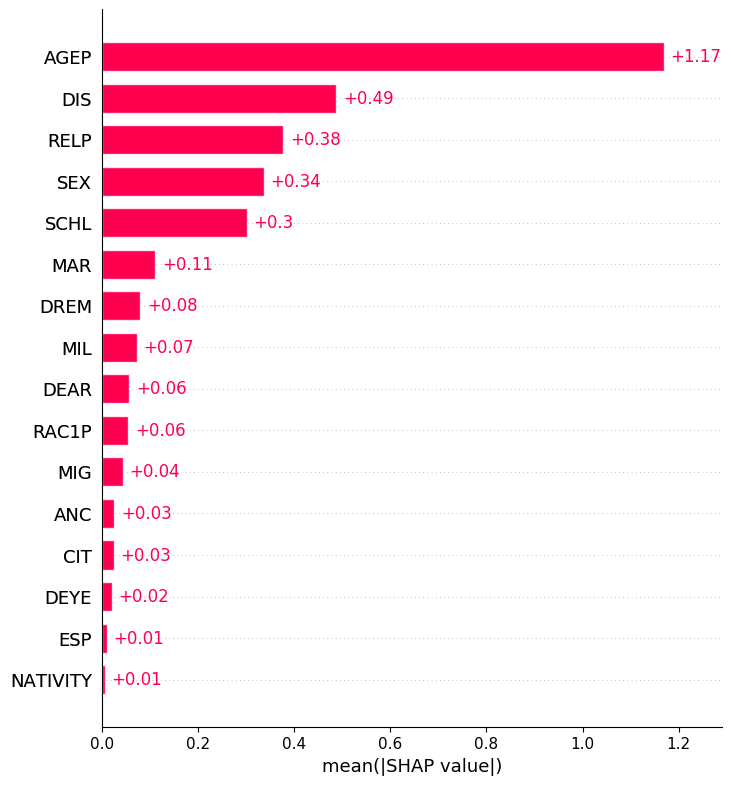

In [40]:
plt.figure(figsize=(12, 12), dpi=100)
shap.plots.bar(cb_shap, max_display=17, show=False)
plt.show()

**Bar chart with feature importance (split by cohorts)**

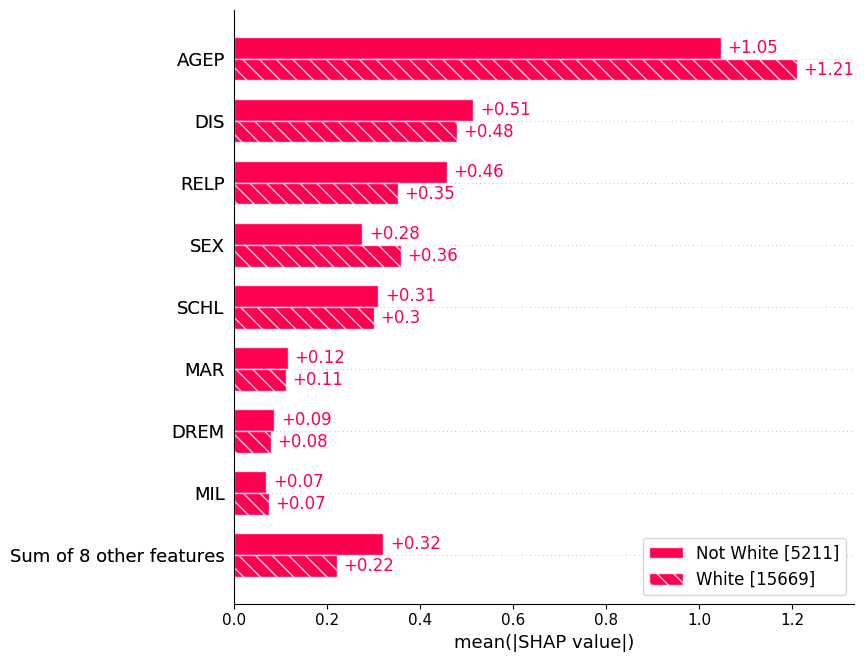

In [43]:
plt.figure(figsize=(12, 12), dpi=100)
race_cohort = np.where(X_test.RAC1P == 1, "White", "Not White")
shap.plots.bar(cb_shap.cohorts(race_cohort).abs.mean(0), max_display=9,\
               show=False)
plt.show()

**Beeswarm plot**

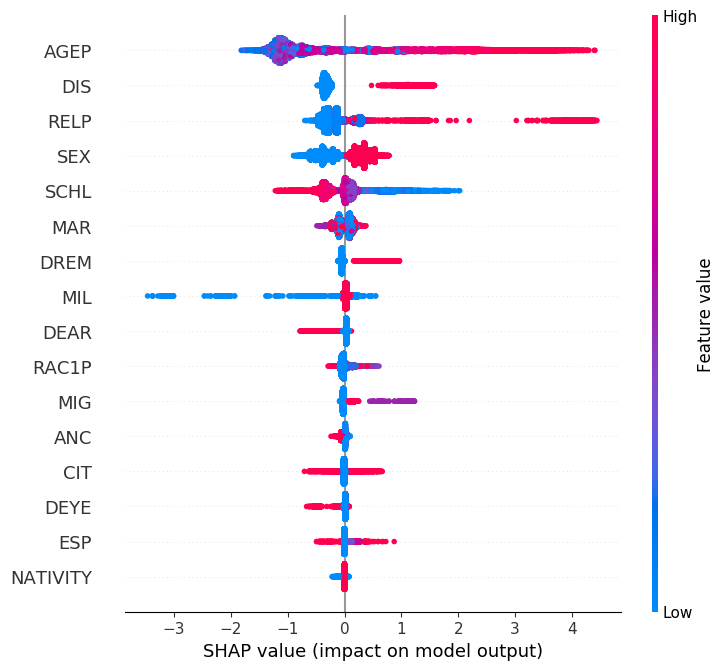

In [45]:
plt.figure(figsize=(12, 12), dpi=100)
shap.plots.beeswarm(cb_shap, max_display=17, show=False)
plt.show()

#### 5.2.2) Feature Summary Explanations

**Partial dependence plots**

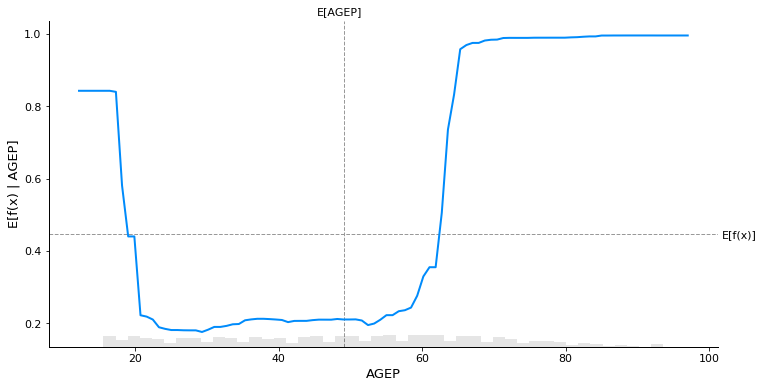

In [48]:
plt.rcParams["figure.figsize"] = (12,6)
shap.plots.partial_dependence("AGEP", cb_mdl.predict, X_test,\
                              ice=False, model_expected_value=True, feature_expected_value=True,\
                              show=False)
plt.show()

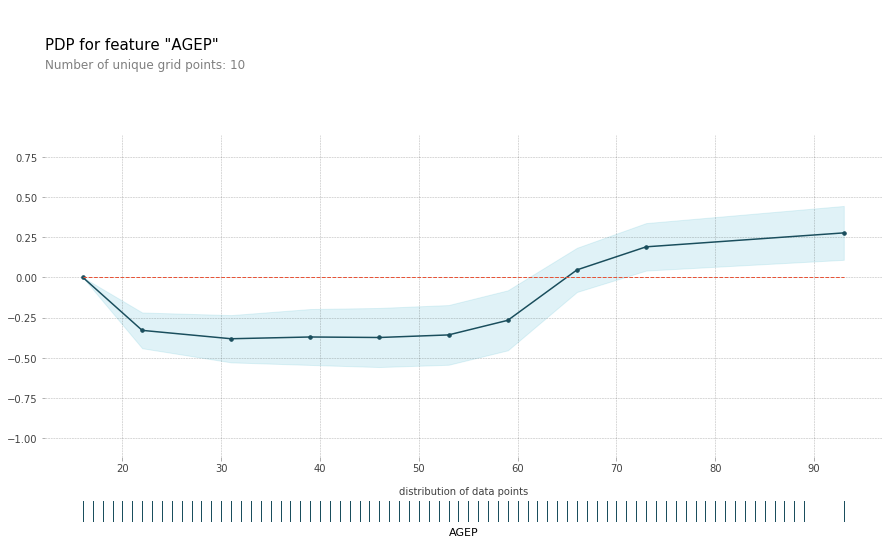

In [49]:
pdp_single_feature = pdp.pdp_isolate(
    model=cb_mdl, dataset=X_test, model_features=feature_l, feature='AGEP'
)
fig, axes = pdp.pdp_plot(pdp_single_feature, 'AGEP', plot_pts_dist=True)
plt.show()

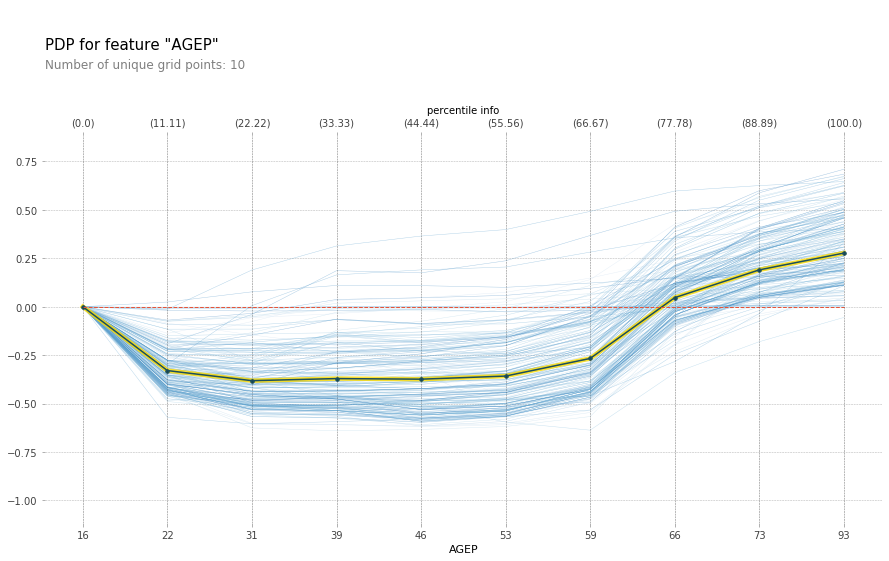

In [50]:
fig, axes = pdp.pdp_plot(
    pdp_single_feature, 'AGEP', plot_lines=True, frac_to_plot=0.01,\
    x_quantile=True, show_percentile=True
)
plt.show()

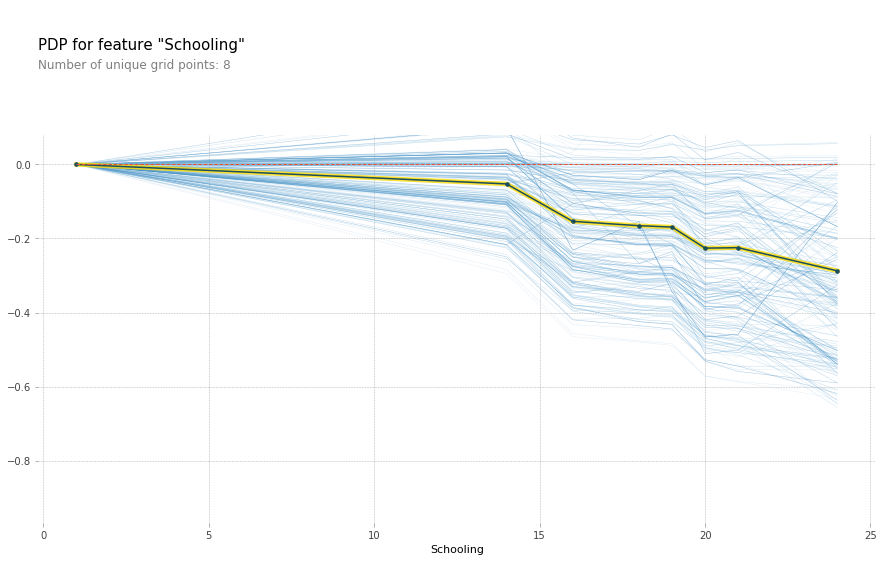

In [52]:
pdp_single_feature = pdp.pdp_isolate(
    model=cb_mdl, dataset=X_test, model_features=feature_l, feature='SCHL'
)
fig, axes = pdp.pdp_plot(
    pdp_single_feature, 'Schooling', plot_lines=True, frac_to_plot=0.01
)
plt.show()

**ALE plot**

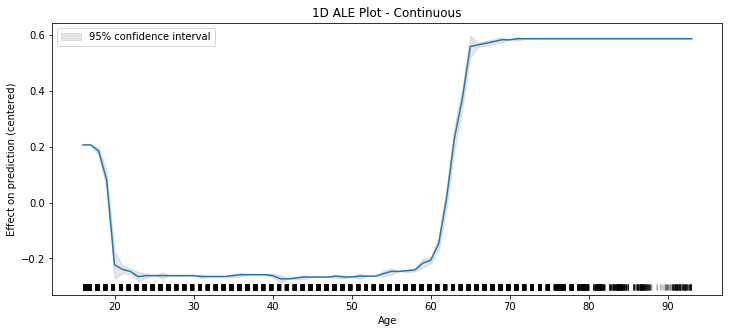

In [ ]:
ale_effect = ale(X=X_test, model=cb_mdl, feature=['Age'], feature_type='continuous',\
                 grid_size=80) 
plt.gcf().set_size_inches(12, 5)
plt.gca().ticklabel_format(useOffset=False, style='plain')
plt.show()

**SHAP scatter plot**

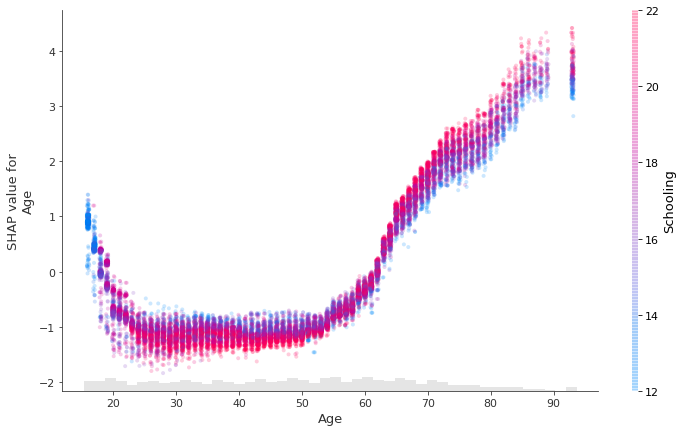

In [ ]:
shap.plots.scatter(cb_shap[:,"Age"], color=cb_shap[:,"Schooling"],\
                   show=False, alpha=0.2, x_jitter=0.4)
plt.gcf().set_size_inches(12, 7)
plt.show()

#### 5.2.3) Feature Interactions

**Clustered bar chart**

In [ ]:
clustering = shap.utils.hclust(X, y)

[14:50:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 19%|█▉        | 3/16 [00:00<?, ?it/s]

[14:50:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 31%|███▏      | 5/16 [00:12<00:13,  1.22s/it]

[14:50:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 38%|███▊      | 6/16 [00:16<00:20,  2.01s/it]

[14:50:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 44%|████▍     | 7/16 [00:19<00:21,  2.37s/it]

[14:50:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 50%|█████     | 8/16 [00:22<00:22,  2.79s/it]

[14:50:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 62%|██████▎   | 10/16 [00:24<00:11,  1.96s/it]

[14:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 69%|██████▉   | 11/16 [00:26<00:09,  1.94s/it]

[14:51:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 75%|███████▌  | 12/16 [00:30<00:09,  2.42s/it]

[14:51:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 81%|████████▏ | 13/16 [00:33<00:07,  2.48s/it]

[14:51:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 88%|████████▊ | 14/16 [00:35<00:04,  2.36s/it]

[14:51:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 94%|█████████▍| 15/16 [00:37<00:02,  2.35s/it]

[14:51:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

100%|██████████| 16/16 [00:39<00:00,  2.35s/it]

[14:51:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

17it [00:41,  3.00s/it]

[14:51:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


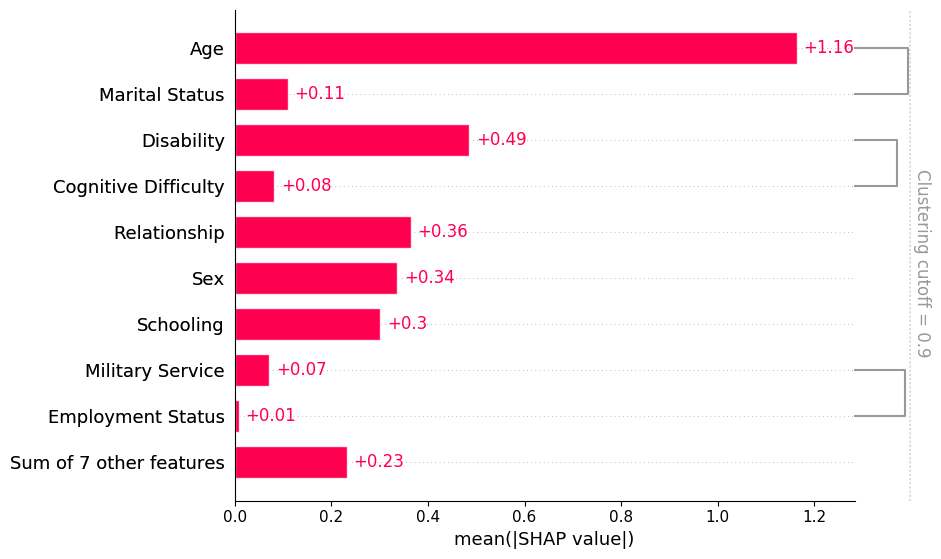

In [ ]:
plt.figure(figsize=(12, 12), dpi=100)
shap.plots.bar(cb_shap, clustering=clustering, clustering_cutoff=0.9,\
               show=False)
plt.show()

**ALE 2D plot**

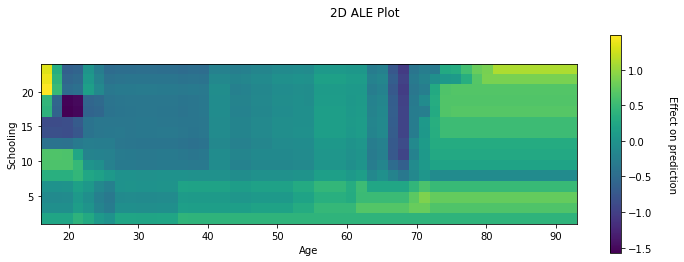

In [ ]:
features_l = ["Schooling", "Age"]
ale_effect = ale(X=X_test, model=cb_mdl, feature=features_l, feature_type='continuous',\
                 grid_size=50) 
plt.gcf().set_size_inches(12, 4) 
plt.gca().ticklabel_format(useOffset=False, style='plain')
plt.show()

**PDP 2D plot**

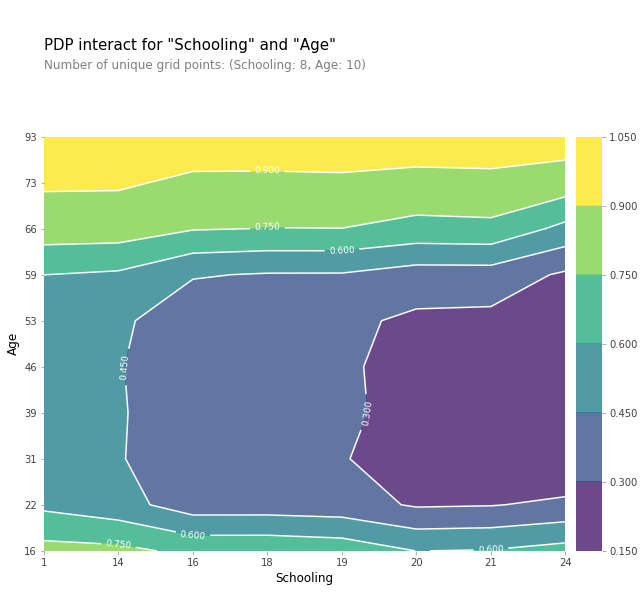

In [ ]:
pdp_interaction_feature = pdp.pdp_interact(
    model=cb_mdl, dataset=X_test, model_features=X_test.columns, features=features_l
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=pdp_interaction_feature, feature_names=features_l, plot_type='contour', x_quantile=True,\
    figsize=(10,10), plot_pdp=False)
plt.show()

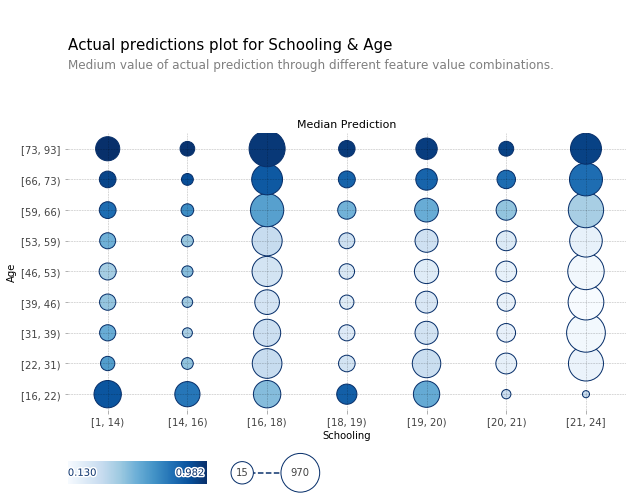

In [ ]:
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=cb_mdl, X=X_test, features=features_l, feature_names=features_l,\
    figsize=(10,9))
plt.show()

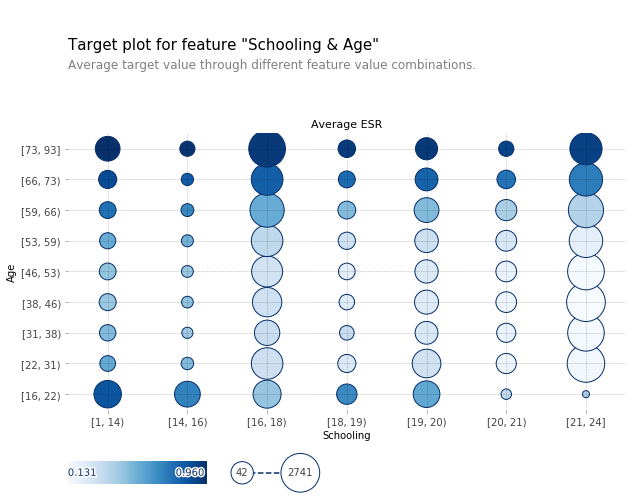

In [ ]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=X_train.join(y_train), target='ESR', features=features_l, feature_names=features_l,\
    figsize=(10,9))
plt.show()

#### 5.2.4) Local Explanations

**Local Interpretable Model-agnostic explanations (LIME)**

In [ ]:
cb_lime = LimeTabularExplainer(X_train.values, mode="classification", class_names=class_l,\
                               feature_names=X_train.columns.tolist(), kernel_width=1, verbose=True)

In [ ]:
i = 20875
print("Observed:  %s" % class_l[y_test.iloc[i]])
cb_lime_exp = cb_lime.explain_instance(X_test.iloc[i].values, cb_mdl.predict_proba)
cb_lime_exp.show_in_notebook()

Observed:  Not Working
Intercept 0.4851320489635769
Prediction_local [0.68142171]
Right: 0.9473192793527526


In [ ]:
i = 28
print("Observed:  %s" % class_l[y_test.iloc[i]])
cb_lime_exp = cb_lime.explain_instance(X_test.iloc[i].values, cb_mdl.predict_proba)
cb_lime_exp.show_in_notebook()

Observed:  Working
Intercept 0.25010712522566336
Prediction_local [1.05185655]
Right: 0.9927882588240411


**SHAP Bar plot**

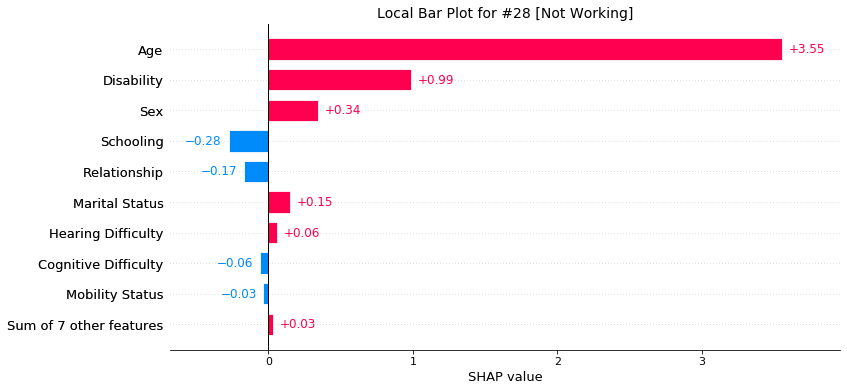

In [ ]:
shap.plots.bar(cb_shap[28], show=False)
plt.gcf().set_size_inches(12, 6)
plt.title('Local Bar Plot for #28 [Not Working]', fontsize=14)
plt.show()

**SHAP waterfall plot**

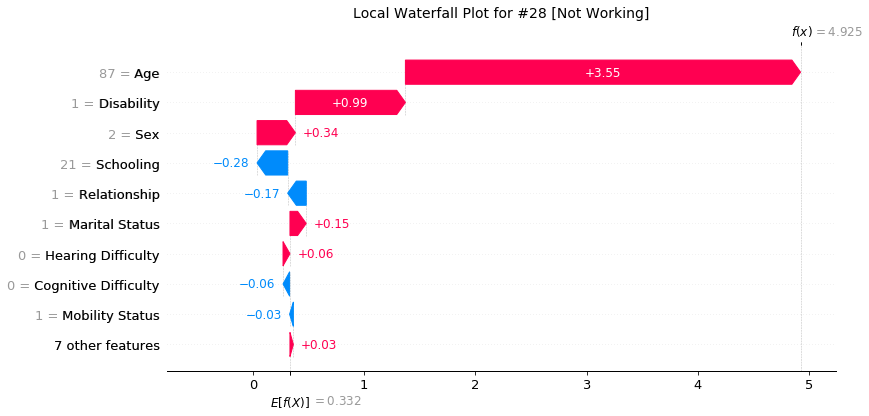

In [ ]:
shap.plots.waterfall(cb_shap[28], show=False)
plt.gcf().set_size_inches(12, 6)
plt.title('Local Waterfall Plot for #28 [Not Working]', fontsize=14)
plt.show()

**SHAP force plot**

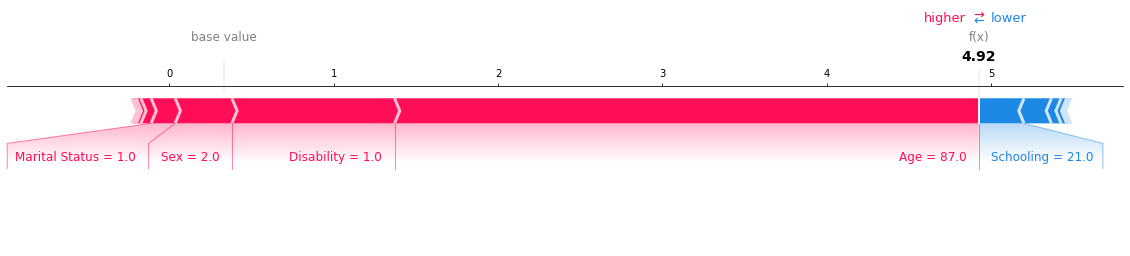

In [ ]:
shap.plots.force(cb_shap[28], matplotlib=True)

**SHAP decision plots**

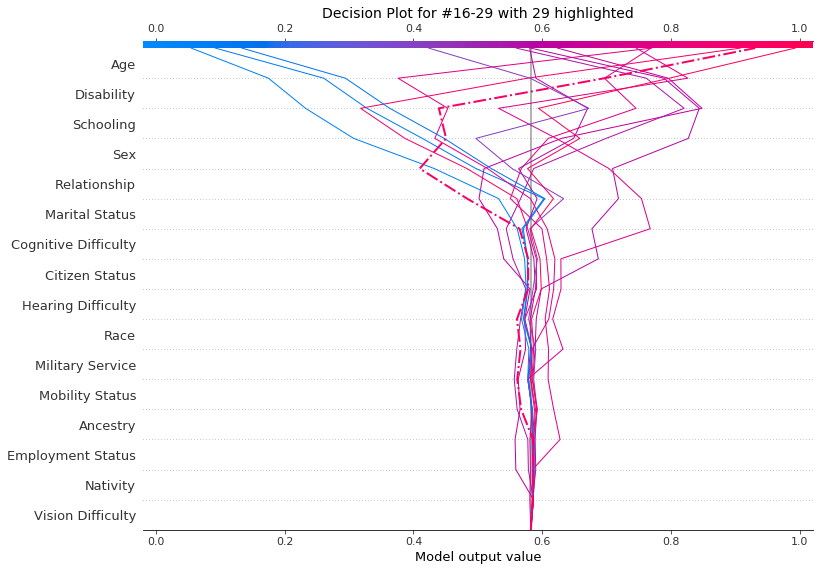

In [ ]:
shap.decision_plot(cb_explainer.expected_value, cb_shap.values[16:30], X_test.iloc[16:30], highlight=13,\
                   show=False, link='logit')
plt.gcf().set_size_inches(12, 9)
plt.title('Decision Plot for #16-29 with 29 highlighted', fontsize=14)
plt.show()

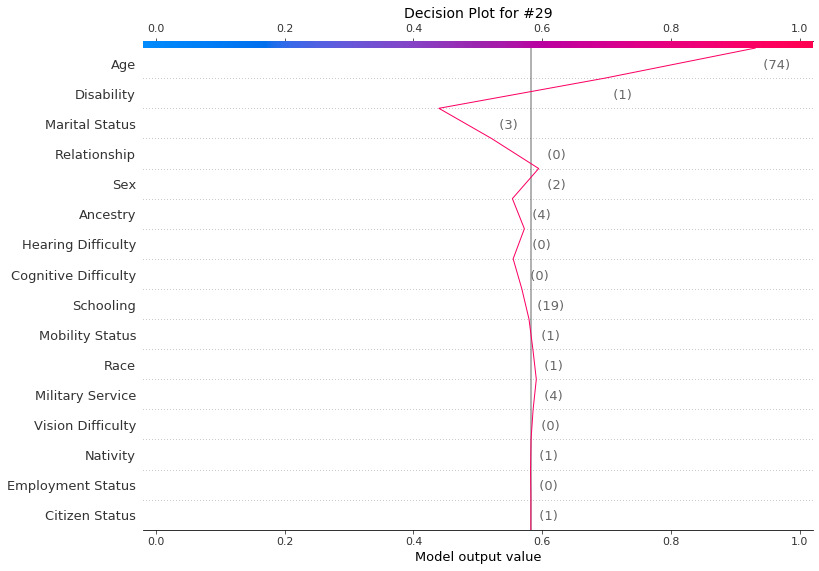

In [ ]:
shap.decision_plot(cb_explainer.expected_value, cb_shap.values[29], X_test.iloc[29],\
                   show=False, link='logit')
plt.gcf().set_size_inches(12, 9)
plt.title('Decision Plot for #29', fontsize=14)
plt.show()